# Домашнее задание 3. 

## Предсказание пользовательской оценки отеля по тексту отзыва.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву. Данные можно скачать [тут](https://www.kaggle.com/c/hseds-texts-2020/data?select=train.csv).

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 1. В противном случае мы будем вынуждены не засчитать задание :( 

Для измерения качества вашей модели используйте разбиение данных на train и test и замеряйте качество на тестовой части.

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Удачи! 💪

#### Использовать внешние данные для обучения строго запрещено. Можно использовать предобученные модели из torchvision.

In [1]:
!wget https://www.dropbox.com/s/ide2hj0nzk8mlw2/hseds-texts-2020.zip
!unzip -q hseds-texts-2020.zip
!ls -l

--2020-12-21 01:29:17--  https://www.dropbox.com/s/ide2hj0nzk8mlw2/hseds-texts-2020.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ide2hj0nzk8mlw2/hseds-texts-2020.zip [following]
--2020-12-21 01:29:17--  https://www.dropbox.com/s/raw/ide2hj0nzk8mlw2/hseds-texts-2020.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a92c1b490c577b7cce7c37da0.dl.dropboxusercontent.com/cd/0/inline/BFevpc8P3WD0lGhh-ved0YJ3rqUfguZEOpmjbKiaRizGXYUKiTd4S_PIbDp6qBjsCLNDzB4OuShJUH_Z17gkvKTo8xvwnyeLEss_98geWE5x9e0vppmrGRPXUsLCRut6R-o/file# [following]
--2020-12-21 01:29:17--  https://uc2a92c1b490c577b7cce7c37da0.dl.dropboxusercontent.com/cd/0/inline/BFevpc8P3WD0lGhh-ved0YJ3rqUfguZEOpmjbKiaRizGXYUKiTd4S_PIbDp6qBjsCLNDzB4OuShJUH_Z17gkvKT

In [64]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
PATH_TO_TRAIN_DATA = './train.csv'

In [4]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_text(text):
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text.lower()) if (word not in string.punctuation) and (word not in stop_words)]

In [6]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [7]:
df_train, df_test = train_test_split(df, random_state=7)

In [8]:
df_train.head()

,review_id,negative,positive,score
48918,7d780ebafd80cbc60668d5767bffb3b9,"[room, hallway, look, little, dated, building,...","[quiet, hotel, close, city, centre, clean, bre...",8.3
11580,1df7393919c10d22daab9a24c0b333fe,"[initial, check, staff, curt]",[positive],9.2
55066,8cf44c93a0121361cc03c3728d1fa85e,"[nothing, like]","[bed, really, comfortable, everywhere, clean, ...",9.2
7647,13fa8c3d3314da14afa14cb21857b841,[negative],"[hotel, quiet, comfortable, really, nice, area...",9.2
35031,5a0e4d195331de557776a1ebf168ce39,[none],"[nothing, special, everything, fine, excellent...",8.3


### Часть 1. 1 балл

Объединим вектора positive и negative. Отдельно выделим X_train, y_train, X_test, y_test.

In [9]:
X_train = df_train['negative'] + df_train['positive']
y_train = df_train['score']
X_test = df_test['negative'] + df_test['positive']
y_test = df_test['score']

In [10]:
X_train.head()

48918    [room, hallway, look, little, dated, building,...
11580              [initial, check, staff, curt, positive]
55066    [nothing, like, bed, really, comfortable, ever...
7647     [negative, hotel, quiet, comfortable, really, ...
35031    [none, nothing, special, everything, fine, exc...
dtype: object

In [11]:
X_train_text = [' '.join(i) for i in X_train]
X_test_text = [' '.join(i) for i in X_test]

In [12]:
X_train_text[:5]

['room hallway look little dated building quite dark quiet hotel close city centre clean breakfast average',
 'initial check staff curt positive',
 'nothing like bed really comfortable everywhere clean breakfast excellent',
 'negative hotel quiet comfortable really nice area stone throw eiffel tower',
 'none nothing special everything fine excellent location convenient small purchase cafe']

In [13]:
len(X_train_text)

75000

Загружая такое количество данных, ОЗУ полностью заполняется, поэтому возьму часть данных.

In [14]:
X_train_text_part = X_train_text[:40000]
y_train_part = y_train[:40000]
X_test_text_part = X_test_text[:20000]
y_test_part = y_test[:20000]

Обучите логистическую регрессию на TF-IDF векторах текстов.

In [15]:
tfidf_vect = TfidfVectorizer()

In [16]:
X_train_tfidf =  tfidf_vect.fit_transform(X_train_text_part)
X_test_tfidf = tfidf_vect.transform(X_test_text_part)

In [17]:
X_train_tfidf = X_train_tfidf.toarray()

In [18]:
lin_model = SGDRegressor()
lin_model.fit(X_train_tfidf, y_train_part)

del X_train_tfidf

In [19]:
X_test_tfidf = X_test_tfidf.toarray()
y_pred = lin_model.predict(X_test_tfidf)
print(f'MAE: {mean_absolute_error(y_test_part, y_pred)}')

del X_test_tfidf

MAE: 0.9522221976601526


### Часть 2. 3 балла

Обучите логистическую регрессию на усредненных Word2Vec векторах. 

In [20]:
X_train_part = X_train[:40000]
X_test_part = X_test[:20000]

In [42]:
w2v = Word2Vec(X_train_part, min_count=1)

In [43]:
X_train_part[:5]

48918    [room, hallway, look, little, dated, building,...
11580              [initial, check, staff, curt, positive]
55066    [nothing, like, bed, really, comfortable, ever...
7647     [negative, hotel, quiet, comfortable, really, ...
35031    [none, nothing, special, everything, fine, exc...
dtype: object

In [44]:
def calc_mean_embeds(X, size):
  mean_embeds = []
  for i in range(len(X)):
    sum_embed = np.zeros(size)
    sentence = np.array(X)[i]
    len_sentence = len(sentence)
    if len_sentence == 0:
      mean_embeds.append(sum_embed)
    else:
      for j in sentence:
          try:
            word_embed = w2v[j]
            sum_embed += word_embed
          except KeyError:
            continue

      mean_embed = sum_embed / len_sentence
      mean_embeds.append(mean_embed)

  return np.array(mean_embeds)

In [45]:
X_train_mean_embeds = calc_mean_embeds(X_train_part, 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [46]:
X_test_mean_embeds = calc_mean_embeds(X_test_part, 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [47]:
X_train_mean_embeds

array([[-0.70328436, -0.47079123,  0.43118769, ..., -0.53426798,
         0.21438275,  0.33311336],
       [-0.4705393 , -0.45138839,  0.30432983, ..., -0.19943863,
        -0.27657032,  0.00682743],
       [-0.25757051, -0.68724644,  0.42336647, ..., -0.20546688,
         0.76284878,  0.72255952],
       ...,
       [-0.72733141, -0.13699526,  0.38425547, ..., -0.62417981,
         0.52860736, -0.3817087 ],
       [ 0.06391368, -0.459142  ,  0.50438889, ..., -0.6809098 ,
         0.55279067,  0.13077754],
       [-0.22860216, -0.48160103,  0.27929893, ...,  0.05274016,
         0.13866522,  0.1105703 ]])

In [48]:
lin_model = SGDRegressor()
lin_model.fit(X_train_mean_embeds, y_train_part)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [49]:
y_pred = lin_model.predict(X_test_mean_embeds)
print(f'MAE: {mean_absolute_error(y_test_part, y_pred)}')

MAE: 1.0575566592514014


Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [50]:
def calc_idf(texts):
    tfidf_vect_def = TfidfVectorizer()
    tfidf_vect_def.fit(texts)
    return dict(zip(tfidf_vect_def.get_feature_names(), tfidf_vect_def.idf_))

In [51]:
X_train_part_text = [' '.join(i) for i in X_train_part]
X_train_part_idf = calc_idf(X_train_part_text)

In [ ]:
X_train_part_idf

In [53]:
def calc_idf_embeds(X, size):
  idf_embeds = []
  for i in range(len(X)):
    sum_embed = np.zeros(size)
    sentence = np.array(X)[i]
    len_sentence = len(sentence)
    if len_sentence == 0:
      idf_embeds.append(sum_embed)
    else:
      for j in sentence:
          try:
            word_idf = X_train_part_idf[j]
            word_embed = w2v[j]
            sum_embed += word_embed * word_idf
          except KeyError:
            continue

      idf_embed = sum_embed / len_sentence
      idf_embeds.append(idf_embed)

  return np.array(idf_embeds)

In [54]:
X_train_idf_embeds = calc_idf_embeds(X_train_part, 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [55]:
X_test_idf_embeds = calc_idf_embeds(X_test_part, 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [56]:
X_train_mean_embeds

array([[-0.70328436, -0.47079123,  0.43118769, ..., -0.53426798,
         0.21438275,  0.33311336],
       [-0.4705393 , -0.45138839,  0.30432983, ..., -0.19943863,
        -0.27657032,  0.00682743],
       [-0.25757051, -0.68724644,  0.42336647, ..., -0.20546688,
         0.76284878,  0.72255952],
       ...,
       [-0.72733141, -0.13699526,  0.38425547, ..., -0.62417981,
         0.52860736, -0.3817087 ],
       [ 0.06391368, -0.459142  ,  0.50438889, ..., -0.6809098 ,
         0.55279067,  0.13077754],
       [-0.22860216, -0.48160103,  0.27929893, ...,  0.05274016,
         0.13866522,  0.1105703 ]])

In [57]:
lin_model_idf = SGDRegressor()
lin_model_idf.fit(X_train_idf_embeds, y_train_part)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [58]:
y_pred = lin_model.predict(X_test_idf_embeds)
print(f'MAE: {mean_absolute_error(y_test_part, y_pred)}')

MAE: 3.165351632078932


In [59]:
sizes = list(range(100, 350, 50))
sizes

[100, 150, 200, 250, 300]

Возьмем в этот раз полные выборки тренировочного и тестового датасетов без урезания.

In [60]:
mae_mean = []
mae_idf = []
for size in sizes:
  w2v = Word2Vec(X_train, min_count=1, size=size)
  X_train_mean_embeds = calc_mean_embeds(X_train, size)
  X_test_mean_embeds = calc_mean_embeds(X_test, size)
  X_train_idf_embeds = calc_idf_embeds(X_train, size)
  X_test_idf_embeds = calc_idf_embeds(X_test, size)

  lin_model_mean = SGDRegressor()
  lin_model_mean.fit(X_train_mean_embeds, y_train)
  lin_model_idf = SGDRegressor()
  lin_model_idf.fit(X_train_idf_embeds, y_train)

  y_pred_mean = lin_model_mean.predict(X_test_mean_embeds)
  mae_mean.append(mean_absolute_error(y_test, y_pred_mean))
  y_pred_idf = lin_model_idf.predict(X_test_idf_embeds)
  mae_idf.append(mean_absolute_error(y_test, y_pred_idf))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.

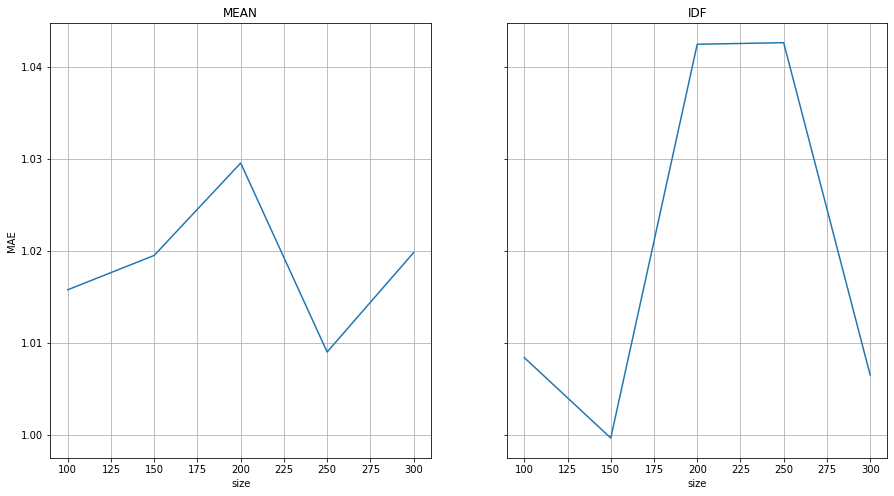

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.lineplot(x=sizes, y=mae_mean, ax=ax[0])
sns.lineplot(x=sizes, y=mae_idf, ax=ax[1])
ax[0].set_title('MEAN')
ax[1].set_title('IDF')
ax[0].set_xlabel('size')
ax[1].set_xlabel('size')
ax[0].set_ylabel('MAE')
ax[0].grid()
ax[1].grid()

plt.show()

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 
#### Сделайте выводы: заметим, что на небольших размерностью эмбеддингах метрика качества MAE ниже при idf до 150. Только, начиная с эмбэддинга размерностью 300 снова, метрика качества ниже при idf, чем при усреднении. Поэтому имеет смысл взять эмбэддинг больше 300, чтобы добиться MAE меньше при использовании idf. Кроме этого, видим, что при усреднении метрика качества не снижается ниже, чем 1.01, а при idf - 1.

In [62]:
w2v = Word2Vec(X_train, min_count=1, size=300)
X_train_idf_embeds = calc_idf_embeds(X_train, 300)
X_test_idf_embeds = calc_idf_embeds(X_test, 300)
lin_model_idf = RidgeCV(cv=5)
lin_model_idf.fit(X_train_idf_embeds, y_train)
y_pred_idf = lin_model_idf.predict(X_test_idf_embeds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [63]:
print(f'MAE: {mean_absolute_error(y_test, y_pred_idf)}')

MAE: 0.9828782867762176


Теперь попробуйте обучить логистическую регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
#### Выводы:

### Часть 3. 6 баллов

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки. Получите ошибку меньше, чем во всех вышеперечисленных методах.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

In [ ]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [ ]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [ ]:
MAX_LEN = max(max(df['positive'].apply(len)), max(df['negative'].apply(len)))

In [ ]:
MAX_LEN

399

In [ ]:
from torch.nn.utils.rnn import pad_sequence

train_pos_pad = pad_sequence([torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in df_train['positive']], 
                           batch_first=True)

In [ ]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        ## TODO
        pass
        
    def __len__(self):
        ## TODO
        pass
    
    def __getitem__(self, idx):
        ## TODO
        pass

In [ ]:
BATCH_SIZE = 1

train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_EPOCHS = 1

for n in range(NUM_EPOCHS):
    model.train()
    ## TODO

### Бонус. 10 баллов

Побейте качество 0.75 в [соревновании](https://www.kaggle.com/c/hseds-texts-2020/leaderboard). Можете воспользоваться вышеперечисленными методами или попробовать что-нибудь еще.